# CNN 303
Try to use TensorFlow Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D).

Follow this [tutorial](https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/) on MissingLink.ai

One-hot encoding of individual nucleotides will provide the required feature vector, small though it will be. Use Keras [one-hot](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/one_hot)?

Keras convolution layers do not take a [padding/masking](https://www.tensorflow.org/guide/keras/masking_and_padding) parameter.

Relevant [paper](https://academic.oup.com/nargab/article/2/1/lqz024/5701461?login=true) uses Conv1D.

In [11]:
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='CNN303'  
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=100
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=16
KERNEL=3
NEURONS=16
DROP=0.25
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
# Load our own tools
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

In [14]:
# Once this works, move this to our tools library.
def onehot(seqs): 
    # Input list of digits from alphabet {0..4} .
    # Return array of (5-bit bit-vectors) 
    newX = []
    vectors=[]
    vectors.append([1,0,0,0,0]) # 0 = N
    vectors.append([0,1,0,0,0]) # 1 = A
    vectors.append([0,0,1,0,0]) # 2 = C
    vectors.append([0,0,0,1,0]) # 3 = G
    vectors.append([0,0,0,0,1]) # 4 = T
    for seq in X_train:
        letters=[]
        for num in seq:
            hot = vectors[num]
            letters.append(hot)
        newX.append(letters)
    return np.asarray(newX)

In [15]:
# Once this works, move this to our tools library.
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

Build model

In [16]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    #embed_layer  = keras.layers.Embedding(
    #    input_dim=VOCABULARY_SIZE, output_dim=4, mask_zero=True)
    SHAPE=(1000,5)  # 1000 time steps, 5 features
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[1000])
    #dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    #cnn.add(embed_layer)
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    #cnn.add(clayer4)
    #cnn.add(clayer5)
    #cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    #cnn.add(dlayer2)
    cnn.add(dlayer3)
    #cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [17]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

## to do:
Stop calling make_kmers() then onehot().
We're only using make_kmers convert ACGT to 1234.
Instead, write an RNA_to_onehot() function.

In [18]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
# print(X_train.shape)
print("First sequence as ints")
print(X_train[0])  
X_train=onehot(X_train)
print("First sequence as onehot")
print(X_train[0])  

Load data from files.
Ready: train_set
Data reshape
First sequence as ints
[4 2 1 4 2 1 3 4 2 2 1 1 1 3 4 2 2 1 3 2 1 3 4 4 3 4 2 2 2 4 2 2 4 3 3 1 1
 4 2 2 3 4 4 3 3 2 4 4 3 2 2 4 2 2 3 3 2 1 4 4 4 4 4 3 3 2 2 2 4 4 3 2 2 4
 4 4 4 1 3 3 3 4 4 3 2 2 1 3 1 4 4 1 1 1 1 3 1 2 1 3 3 1 4 3 2 2 2 1 3 2 4
 1 3 4 4 4 3 1 1 4 4 4 4 1 3 1 4 1 1 1 2 1 1 2 3 1 1 4 1 1 4 4 4 2 3 4 1 3
 2 1 4 1 1 1 4 1 4 3 4 2 2 2 1 1 3 2 4 4 1 3 4 4 4 3 3 3 1 2 1 4 1 2 4 4 1
 4 3 2 4 1 1 1 1 1 1 2 1 4 4 1 4 4 3 3 4 4 3 4 4 4 1 4 2 4 3 1 3 1 4 4 2 1
 3 1 1 4 4 1 1 3 2 1 4 4 4 4 1 4 1 4 4 4 4 1 4 4 4 3 2 4 3 2 2 4 2 4 3 3 2
 2 1 2 2 2 4 1 2 4 2 4 2 4 4 2 2 4 1 1 2 1 2 4 2 4 2 4 2 2 2 4 2 4 2 2 2 1
 3 4 4 4 4 3 4 2 2 3 2 2 4 4 2 2 2 4 3 2 2 4 2 2 4 2 4 4 2 4 3 3 3 3 3 1 3
 4 4 1 3 1 4 2 3 1 3 4 4 3 4 1 1 2 1 1 3 1 1 2 1 4 3 2 2 1 2 4 3 4 2 4 2 3
 2 4 3 3 2 4 3 2 1 3 2 3 4 3 4 3 3 4 2 2 2 2 4 4 1 2 2 1 3 1 3 4 3 1 3 3 1
 4 3 2 3 1 1 3 1 3 1 1 3 3 4 3 3 2 4 3 4 2 4 3 2 1 1 1 2 2 1 3 3 1 1 3 1 3
 1 3 2 2 2 4 2 1 2 2 3 3 

In [19]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1000, 16)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1000, 16)          784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                128016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
___________________________________________________________

Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 2s 4ms/step - loss: 0.5703 - accuracy: 0.6970 - val_loss: 0.5109 - val_accuracy: 0.7474
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.1.best/assets
Epoch 2/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4807 - accuracy: 0.7648 - val_loss: 0.5147 - val_accuracy: 0.7467
Epoch 3/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4053 - accuracy: 0.8164 - val_loss: 0.5366 - val_accuracy: 0.7505
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.1.best/assets
Epoch 4/100
453/453 [==============================] - 2s 4ms/step - loss: 0.3016 - accuracy: 0.8792 - val_loss: 0.5543 - val_accuracy: 0.7641
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.1.best/assets
Epoch 5/100
453/453 [==============================] - 2s 4ms/step - loss: 0.2029 - accuracy: 0.9308 - val_loss: 0.6739 -

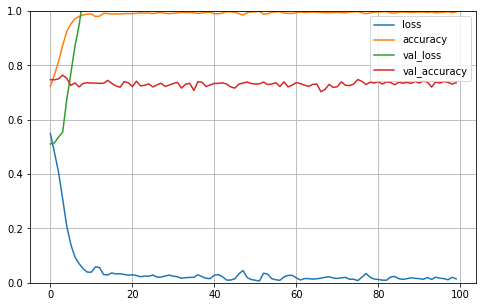

accuracy: 76.41%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 2s 4ms/step - loss: 0.5856 - accuracy: 0.6993 - val_loss: 0.5319 - val_accuracy: 0.7405
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.2.best/assets
Epoch 2/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4851 - accuracy: 0.7642 - val_loss: 0.5293 - val_accuracy: 0.7461
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.2.best/assets
Epoch 3/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4023 - accuracy: 0.8190 - val_loss: 0.5584 - val_accuracy: 0.7436
Epoch 4/100
453/453 [==============================] - 2s 4ms/step - loss: 0.3147 - accuracy: 0.8700 - val_loss: 0.7116 - val_accuracy: 0.6859
Epoch 5/100
453/453 [==============================] - 2s 4ms/step - loss: 0.2321 - accuracy: 0.9116 - val_loss: 0.7215 - val_accuracy: 0.7318
Epoch 6/100
453/453 [==============================] - 2s 4ms/ste

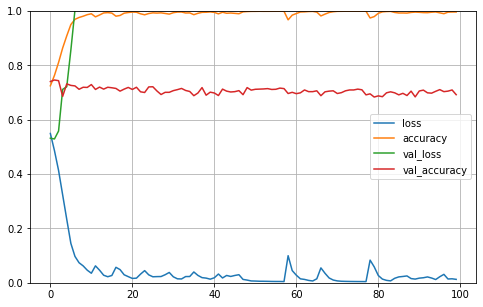

accuracy: 74.61%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 2s 4ms/step - loss: 0.5923 - accuracy: 0.6889 - val_loss: 0.5332 - val_accuracy: 0.7356
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.3.best/assets
Epoch 2/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4989 - accuracy: 0.7573 - val_loss: 0.5147 - val_accuracy: 0.7542
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.3.best/assets
Epoch 3/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4011 - accuracy: 0.8240 - val_loss: 0.5182 - val_accuracy: 0.7753
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.3.best/assets
Epoch 4/100
453/453 [==============================] - 2s 4ms/step - loss: 0.2839 - accuracy: 0.8915 - val_loss: 0.5562 - val_accuracy: 0.7449
Epoch 5/100
453/453 [==============================] - 2s 4ms/step - loss: 0.1889 - accuracy: 0.9367 - val_loss: 0.6778 

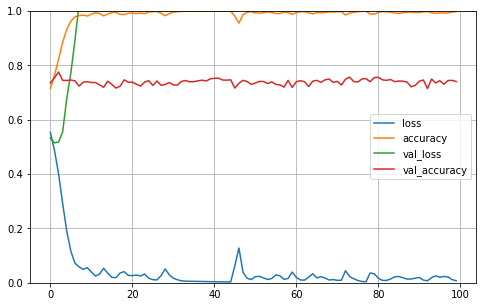

accuracy: 77.53%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 2s 4ms/step - loss: 0.5896 - accuracy: 0.6841 - val_loss: 0.5148 - val_accuracy: 0.7517
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.4.best/assets
Epoch 2/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4902 - accuracy: 0.7625 - val_loss: 0.4939 - val_accuracy: 0.7542
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.4.best/assets
Epoch 3/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4089 - accuracy: 0.8131 - val_loss: 0.4989 - val_accuracy: 0.7647
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.4.best/assets
Epoch 4/100
453/453 [==============================] - 2s 4ms/step - loss: 0.3016 - accuracy: 0.8777 - val_loss: 0.5221 - val_accuracy: 0.7492
Epoch 5/100
453/453 [==============================] - 2s 4ms/step - loss: 0.2151 - accuracy: 0.9213 - val_loss: 0.5820 

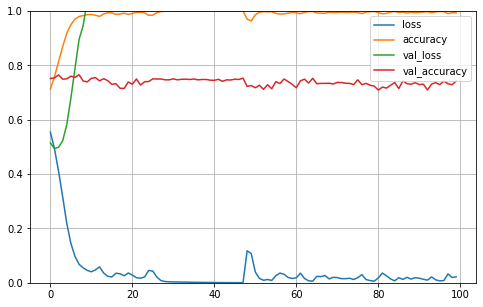

accuracy: 76.54%
COMPILE...
...COMPILED
FIT
Epoch 1/100
453/453 [==============================] - 2s 4ms/step - loss: 0.5661 - accuracy: 0.7020 - val_loss: 0.5230 - val_accuracy: 0.7387
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.5.best/assets
Epoch 2/100
453/453 [==============================] - 2s 4ms/step - loss: 0.4606 - accuracy: 0.7783 - val_loss: 0.5047 - val_accuracy: 0.7604
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.5.best/assets
Epoch 3/100
453/453 [==============================] - 2s 4ms/step - loss: 0.3751 - accuracy: 0.8321 - val_loss: 0.5083 - val_accuracy: 0.7778
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN303.cv.5.best/assets
Epoch 4/100
453/453 [==============================] - 2s 4ms/step - loss: 0.2536 - accuracy: 0.9006 - val_loss: 0.5738 - val_accuracy: 0.7585
Epoch 5/100
453/453 [==============================] - 2s 4ms/step - loss: 0.1537 - accuracy: 0.9475 - val_loss: 0.6524 

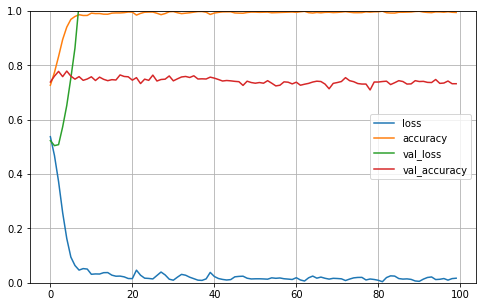

accuracy: 77.90%

5-way Cross Validation mean 76.60% (+/- 1.14%)
Done


In [20]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")